# Analyse des Composantes Principales pour la gestion de portefeuilles d'actions

## Importation des packages

In [1]:
from   pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from   pandas_datareader import data
import seaborn as sns
import sklearn as sk
from   sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

## Vérification des versions

In [2]:
print('Python            version {}'.format(sys.version))
print('Numpy             version {}'.format(np.__version__))
print('Pandas            version {}'.format(pd.__version__))
print('Pandas DataReader version {}'.format(pdr.__version__))
print('Seabron           version {}'.format(sns.__version__))
print('Scikit-Learn      version {}'.format(sk.__version__))
print('Matplotlib        version {}'.format(matplotlib.__version__))

Python            version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy             version 1.21.4
Pandas            version 1.3.2
Pandas DataReader version 0.10.0
Seabron           version 0.11.2
Scikit-Learn      version 1.0.1
Matplotlib        version 3.4.3


In [3]:
# Réglages
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
np.random.seed(167)

In [4]:
# Gestion des sauvegardes
results_path = Path('data', 'results', 'pca')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Récupération des données 

On se focalise sur les N entreprises avec la plus grande capitalisation boursière

In [5]:
# Chargement du fichier comportement les capitalisations boursières
market_cap = pd.read_csv("data/market_cap.csv", index_col=0)
market_cap

,marketCap
A,48856465408
AA,9126754304
AAC,1227499904
AACG,67463472
AACI,202746000
...,...
ZWRK,280600000
ZY,970184512
ZYME,873998144
ZYNE,169543664


In [6]:
# Selection des N plus grandes capitalisations boursières
top_market_cap = market_cap.marketCap.nlargest(28).index
print(list(top_market_cap))

['MSFT', 'AAPL', 'GOOGL', 'GOOG', 'AMZN', 'TSLA', 'FB', 'GE', 'TSM', 'JPM', 'V', 'BABA', 'UNH', 'JNJ', 'HD', 'BAC', 'WMT', 'PG', 'MA', 'ASML', 'ADBE', 'NFLX', 'DIS', 'CRM', 'XOM', 'PFE', 'NKE', 'ORCL']


In [7]:
# On considère les données à partir de 2010 jusqu'à fin 2019
start_date = '2010-01-01'
# end_date   = '2021-11-29'

# On prend pour source Yahoo Finance
source = 'yahoo'

# On charge les cours d'actions à partir de Yahoo Finance grâce au module Pandas_DataReader
stocks = data.DataReader(top_market_cap,    # 28 tickers
                         source,            # Yahoo Finance
                         start_date         # De janv. 2010 à aujourd'hui
                         )[["Adj Close"]].pct_change()
stocks.columns = [k[1] for k in stocks.columns.values]
stocks

,MSFT,AAPL,GOOGL,GOOG,AMZN,TSLA,FB,GE,TSM,JPM,V,BABA,UNH,JNJ,HD,BAC,WMT,PG,MA,ASML,ADBE,NFLX,DIS,CRM,XOM,PFE,NKE,ORCL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000323,0.001729,-0.004404,-0.004404,0.005900,NaN,NaN,0.005178,-0.004318,0.019370,-0.011459,NaN,-0.001586,-0.011595,0.007325,0.032505,-0.009958,0.000327,-0.002959,0.007790,0.016446,-0.036836,-0.002495,-0.004277,0.003905,-0.014263,0.003979,-0.001207
2010-01-06,-0.006137,-0.015906,-0.025209,-0.025209,-0.018116,NaN,NaN,-0.005151,-0.003469,0.005494,-0.013428,NaN,0.009848,0.008134,-0.003463,0.011728,-0.002235,-0.004743,-0.001446,0.009161,-0.002122,0.035139,-0.005314,-0.001745,0.008643,-0.003215,-0.006097,-0.014505
2010-01-07,-0.010400,-0.001849,-0.023280,-0.023280,-0.017013,NaN,NaN,0.051780,-0.033072,0.019809,0.009307,NaN,0.038377,-0.007137,0.011814,0.032947,0.000560,-0.005423,-0.006535,-0.027801,-0.019405,-0.017254,0.000314,-0.004437,-0.003142,-0.003763,0.009815,-0.003271
2010-01-08,0.006896,0.006648,0.013331,0.013331,0.027077,NaN,NaN,0.021538,-0.000900,-0.002456,0.002766,NaN,-0.009391,0.003438,-0.004808,-0.008860,-0.005037,-0.001322,0.000355,-0.023928,-0.005422,0.017176,0.001571,0.001486,-0.004012,0.008095,-0.001974,0.012305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,0.000681,0.003284,0.002319,-0.000269,0.000103,0.006285,0.011297,0.001469,-0.005356,-0.007844,0.023981,0.021398,0.006777,-0.002800,0.009158,0.002737,0.005006,-0.005219,0.033435,-0.006304,0.004751,0.006467,0.002053,-0.007721,0.005544,-0.003720,-0.000697,0.006886
2021-11-26,-0.024356,-0.031678,-0.026944,-0.026660,-0.021185,-0.030538,-0.023280,-0.042942,-0.029989,-0.030127,-0.027552,-0.023220,-0.022770,-0.006490,-0.022834,-0.039261,-0.011191,-0.008005,-0.046559,-0.025387,-0.009307,0.011165,-0.021343,-0.017153,-0.035129,0.061112,-0.023310,-0.013358
2021-11-29,0.021081,0.021874,0.023544,0.023164,0.016267,0.050900,0.014739,0.005724,0.018704,-0.004323,-0.006881,-0.013048,0.027483,0.003455,0.010231,-0.003715,-0.015666,0.010511,-0.003578,0.042186,0.038348,-0.002704,-0.002026,0.044087,0.005551,-0.029630,0.011011,0.006607


In [8]:
# On retire Tesla, Facebook, Alibaba car leur capital n'était pas ouvert en 2010
# On retire GOOG car est (quasiment) un doublon de l'action GOOGL
stocks = stocks.drop(columns=["TSLA", "FB", "BABA", "GOOG"])

## Préparation des données

In [9]:
# On met un seuil à 5% pour les valeurs manquantes
stocks = stocks.dropna(thresh=int(stocks.shape[0] * .95), axis=1)
stocks = stocks.dropna(thresh=int(stocks.shape[1] * .95))
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2999 entries, 2010-01-05 to 2021-12-01
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    2999 non-null   float64
 1   AAPL    2999 non-null   float64
 2   GOOGL   2999 non-null   float64
 3   AMZN    2999 non-null   float64
 4   GE      2999 non-null   float64
 5   TSM     2999 non-null   float64
 6   JPM     2999 non-null   float64
 7   V       2999 non-null   float64
 8   UNH     2999 non-null   float64
 9   JNJ     2999 non-null   float64
 10  HD      2999 non-null   float64
 11  BAC     2999 non-null   float64
 12  WMT     2999 non-null   float64
 13  PG      2999 non-null   float64
 14  MA      2999 non-null   float64
 15  ASML    2999 non-null   float64
 16  ADBE    2999 non-null   float64
 17  NFLX    2999 non-null   float64
 18  DIS     2999 non-null   float64
 19  CRM     2999 non-null   float64
 20  XOM     2999 non-null   float64
 21  PFE     2999 non-nu

## Analyse des covariances

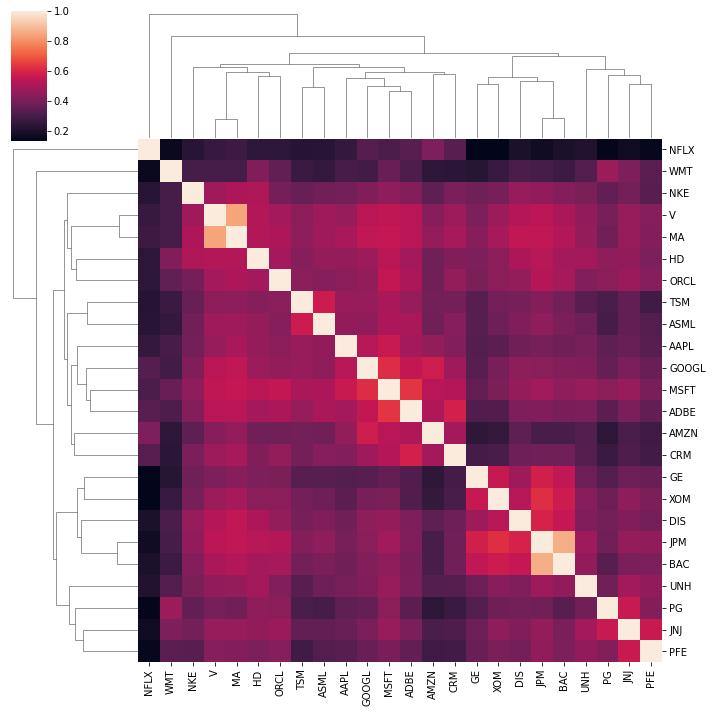

In [10]:
# On calcul les corrélations et covariances
cor = stocks.corr()
cov = stocks.cov()

# On affiche la matrice des corrélations entre les différentes actions d'entreprises
sns.clustermap(cor);

## PCA

In [11]:
# On construit alors les composantes principales
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head(6).style.format('{:,.2%}'.format)

,Explained Variance
0,43.49%
1,24.89%
2,10.73%
3,3.97%
4,2.61%
5,2.19%


In [12]:
# Les 6 premiers axes portent 90% de la variance de l'ensemble des données 
pd.Series(pca.explained_variance_ratio_).head(6).sum()

0.8787312821437769

In [13]:
# On construit les 6 portefeuilles à partir des 6 composantes principales
top_portfolios = pd.DataFrame(pca.components_[:6], columns=cov.columns)
eigen_portfolios = top_portfolios.div(top_portfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 7)]

## Visualisation

#### Définition de fonctions

In [14]:
def portfolios_visualisation(portfolios, save=False):
    """Permet la visualisation des portefeuilles d'actions

    Args:
        portfolios (DataFrame pandas): Ensemble de portefeuilles d'actions
        save (bool, optional): Souhaite-t-on sauvegarder le graphique. Defaults to False.
    """
    axes = portfolios.T.plot.bar(subplots=True,
                                    layout=(6, 2),
                                    figsize=(20, 30),
                                    legend=False)
    for ax in axes.flatten():
        ax.set_ylabel('Portfolio Weight')
        ax.set_xlabel('')
    sns.despine()
    plt.tight_layout()
    if save : plt.savefig(results_path / 'portolios_composition')

In [15]:
def return_visualisation(portfolios, save=False):
    """Permet la visualisation de l'évolution des rendements
    comparativement à la moyenne des rendements et à un portefeuille "naif" équilibré

    Args:
        portfolios (DataFrame pandas): Ensemble de portefeuilles d'actions
        save (bool, optional): Souhaite-t-on sauvegarder le graphique. Defaults to False.
    """
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 6), sharex=True)
    axes = axes.flatten()
    stocks.mean(1).add(1).cumprod().sub(1).plot(title='Market Mean', ax=axes[0])
    stocks.mul(1/stocks.shape[1]).add(1).cumprod().sub(1).sum(1).add(1).plot(title='Balanced Portfolio', ax=axes[1])
    for i in range(6):
        rc = stocks.mul(portfolios.iloc[i]/portfolios.iloc[i].abs().sum()).add(1).cumprod().sub(1).sum(1).add(1)
        rc.plot(title=f'Portfolio {i+1}', ax=axes[i+2], lw=1, rot=0)

    for i in range(7):
        axes[i].set_xlabel('')
    sns.despine()
    fig.tight_layout()
    if save : fig.savefig(results_path / 'long_only_returns')

#### Visualisation des portefeuilles


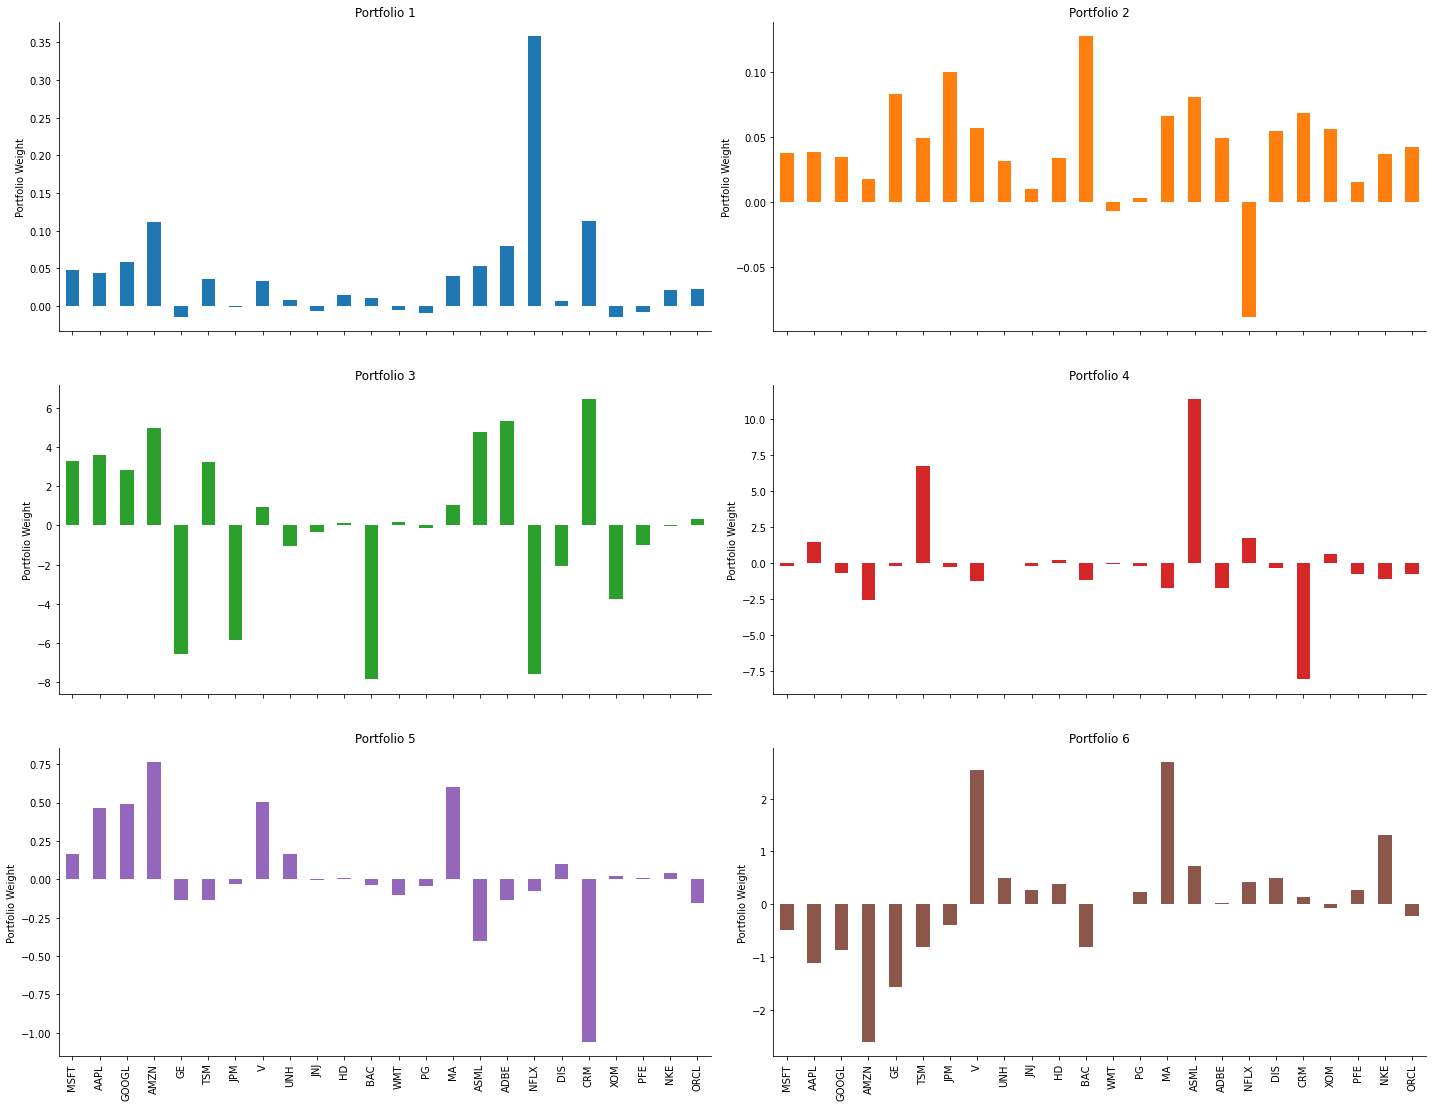

In [16]:
portfolios_visualisation(eigen_portfolios)

#### Visulations des rendements

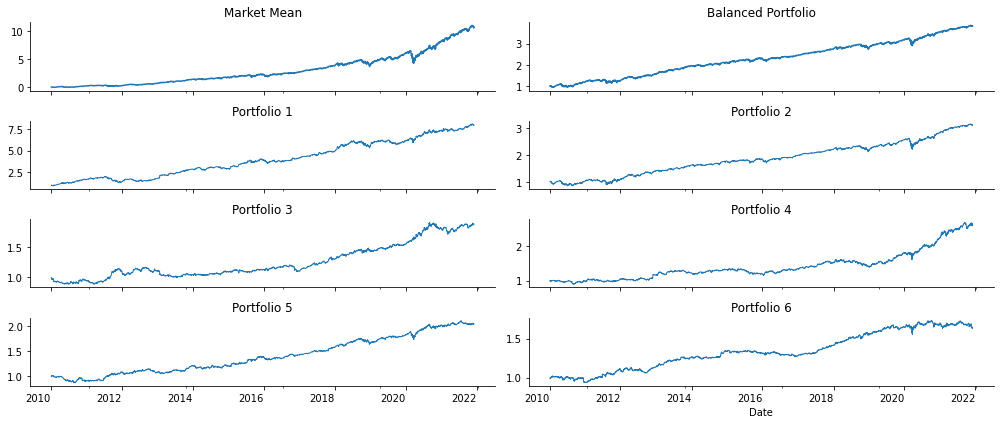

In [17]:
return_visualisation(eigen_portfolios)

In [18]:
# On propose ici d'afficher les rendements finaux des différents portefeuilles
# (depuis le 1er janvier 2010 jusqu'à aujourd'hui)

print("_____Global Return_____")
print('Market Mean     :', round(stocks.mean(1).add(1).cumprod().sub(1)[-1], 1))
print('Balanced Portf. :', round(stocks.mul(1/stocks.shape[1]).add(1).cumprod().sub(1).sum(1).add(1)[-1], 1))

for i in range(6):
    print('Portfolio', i+1, "    :",
          round(stocks.mul(eigen_portfolios.iloc[i]/eigen_portfolios.iloc[i].abs().sum()).add(1).cumprod().sub(1).sum(1).add(1)[-1], 1))


_____Global Return_____
Market Mean     : 10.8
Balanced Portf. : 3.8
Portfolio 1     : 7.9
Portfolio 2     : 3.1
Portfolio 3     : 1.9
Portfolio 4     : 2.6
Portfolio 5     : 2.1
Portfolio 6     : 1.6


## Stratégie *long only*

Aussi en considérant une stratégie *long only*, on obtient les résultats suivants

In [19]:
# On retire toutes les valeurs négatives (short) en les remplaceant par zéro
long_eigen_portfolios = eigen_portfolios.copy()
long_eigen_portfolios[long_eigen_portfolios < 0] = 0

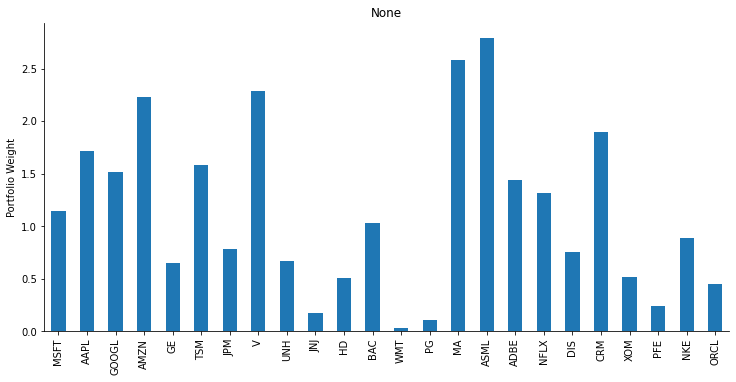

In [20]:
portfolios_visualisation(long_eigen_portfolios.transpose().apply(lambda row : row/row.max()).transpose().sum())

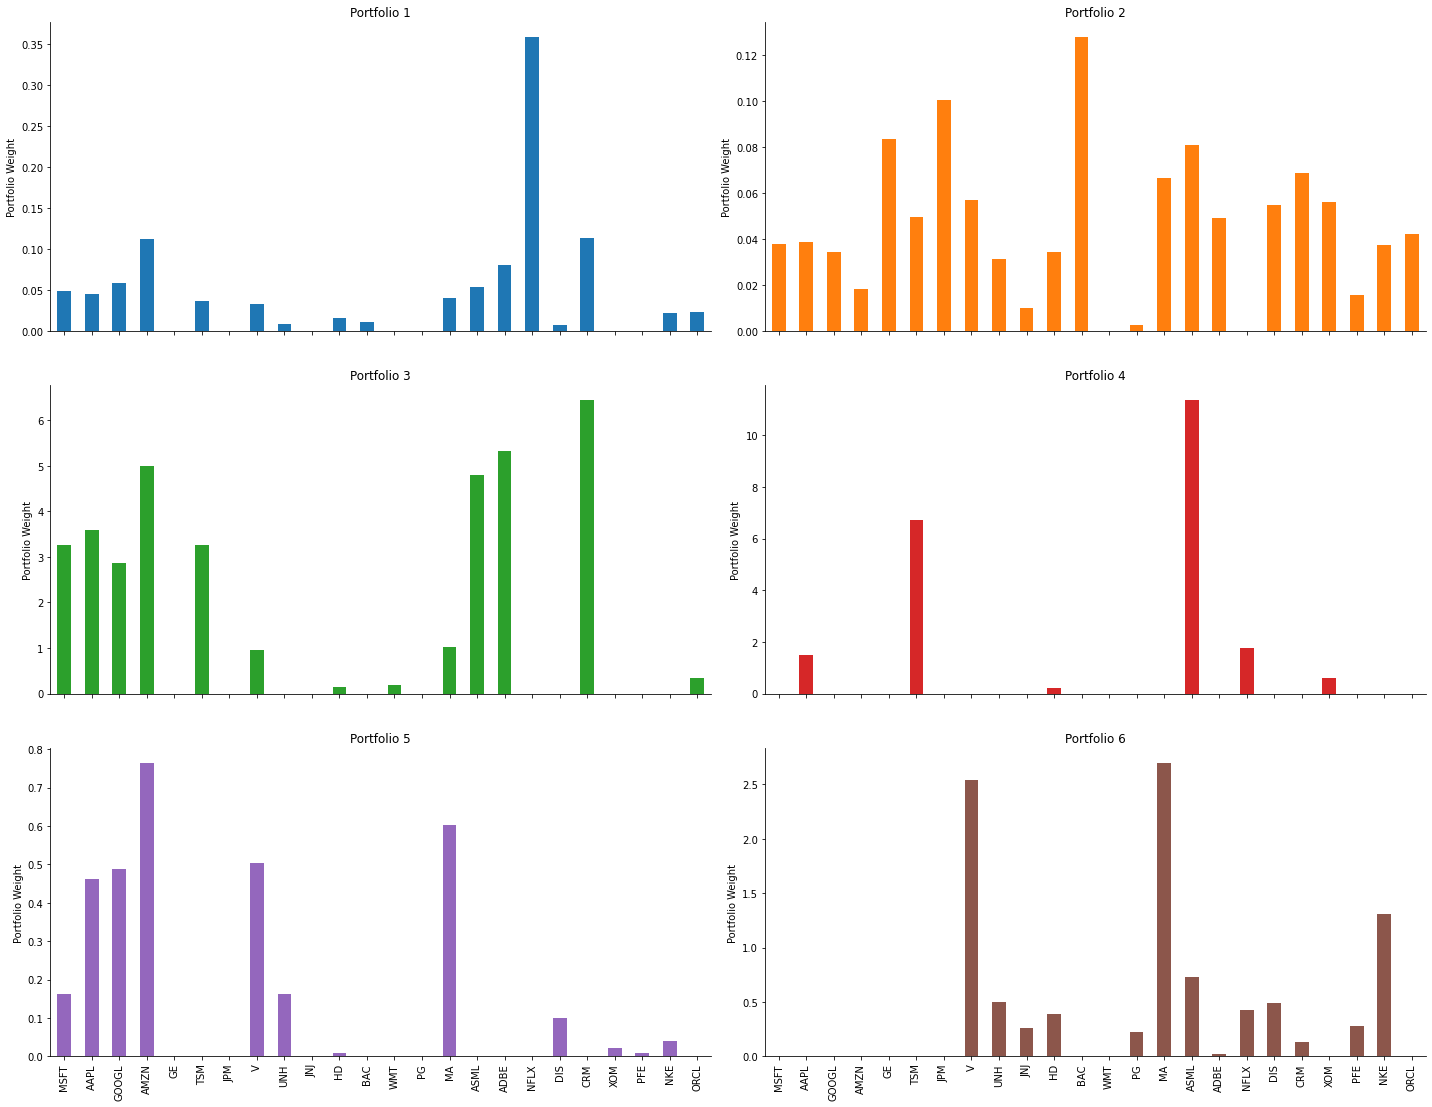

In [21]:
# Visualisation des 6 portefeuilles à stratégie long
portfolios_visualisation(long_eigen_portfolios, save=True)

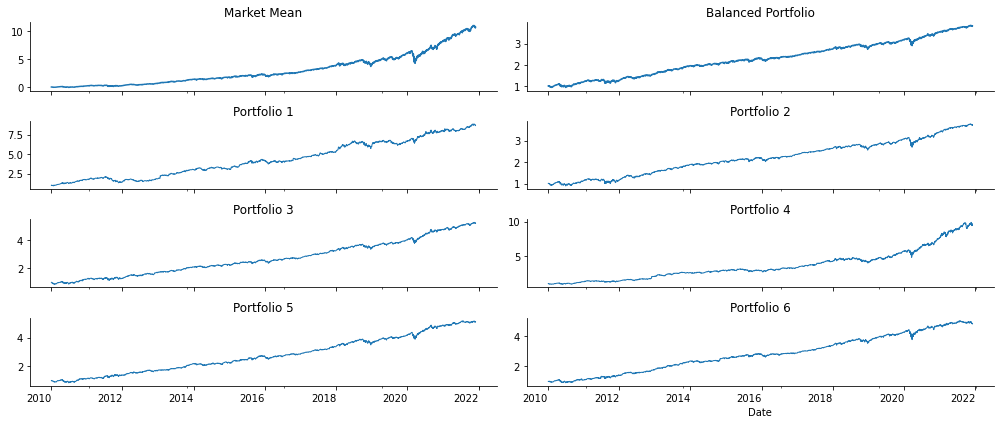

In [22]:
# Visualisation des rendements des 6 portefueilles à stratégie long depuis le 1er janvier 2010
return_visualisation(long_eigen_portfolios, save=True)

In [23]:
# On propose ici d'afficher les rendements finaux des différents portefeuilles 
# Mais également les rendements cumulés dans le cas d'un investissement sur plusieurs portefeuilles
# (depuis le 1er janvier 2010 jusqu'à aujourd'hui)

portfolio_return = [round(stocks.mean(1).add(1).cumprod().sub(1)[-1], 1),
                    round(stocks.mul(1/stocks.shape[1]).add(1).cumprod().sub(1).sum(1).add(1)[-1], 1)]
cumulated_return = portfolio_return.copy()

c=0
for i in range(6):
    r = stocks.mul(long_eigen_portfolios.iloc[i]/long_eigen_portfolios.iloc[i].abs().sum()).add(1).cumprod().sub(1).sum(1).add(1)[-1]
    c+= r
    portfolio_return.append(round(r, 1))
    cumulated_return.append(round(c/(i+1), 1))

d = {'Return': portfolio_return,
     'Cumulated Return': cumulated_return}

df = pd.DataFrame(data = d, index=['Mean Market',
                                   'Balanced Portfolio',
                                   'Portfolio 1',
                                   'Portfolio 2',
                                   'Portfolio 3',
                                   'Portfolio 4',
                                   'Portfolio 5',
                                   'Portfolio 6'])
df

,Return,Cumulated Return
Mean Market,10.8,10.8
Balanced Portfolio,3.8,3.8
Portfolio 1,8.7,8.7
Portfolio 2,3.7,6.2
Portfolio 3,5.2,5.9
Portfolio 4,9.7,6.8
Portfolio 5,5.1,6.5
Portfolio 6,4.8,6.2
